## 전이 학습(VGG16)
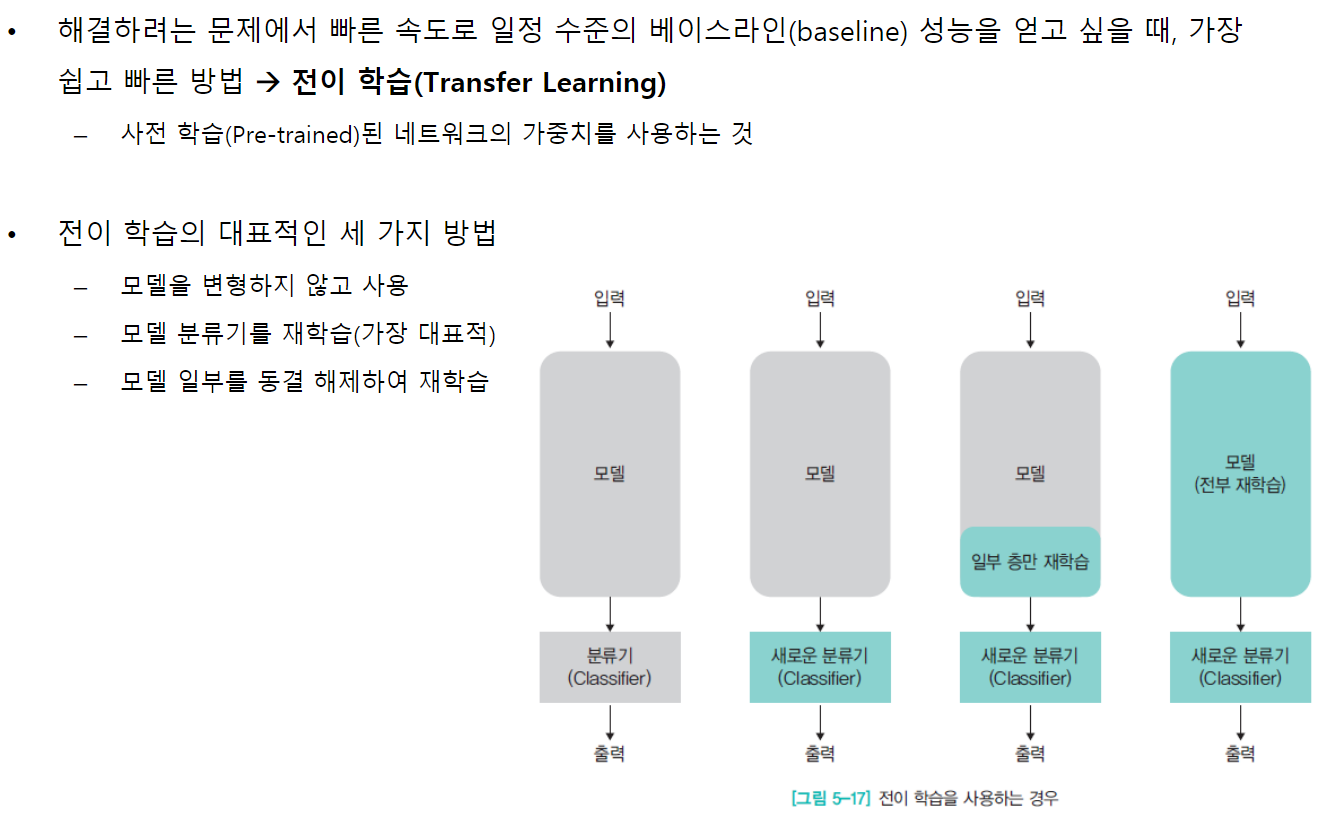

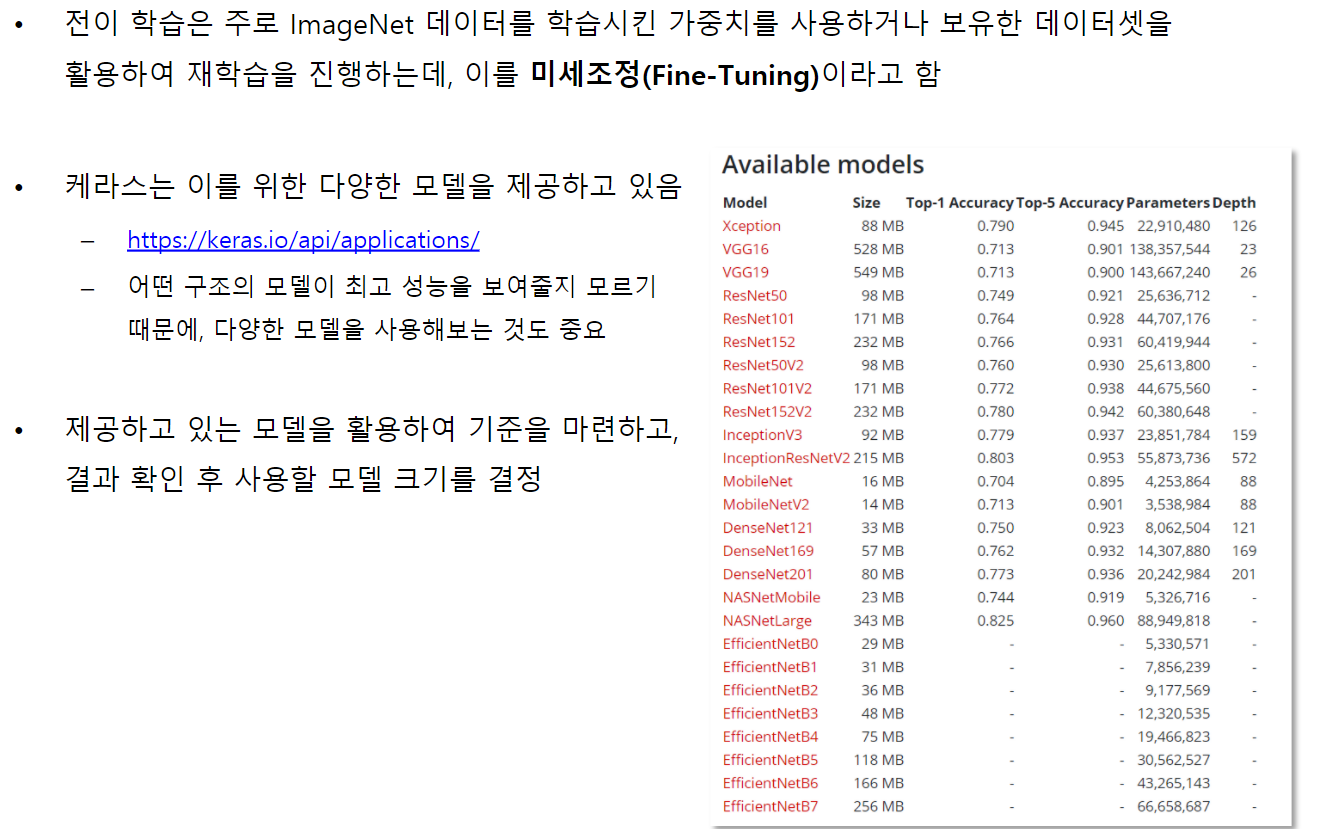

### VGG16 모델 정의
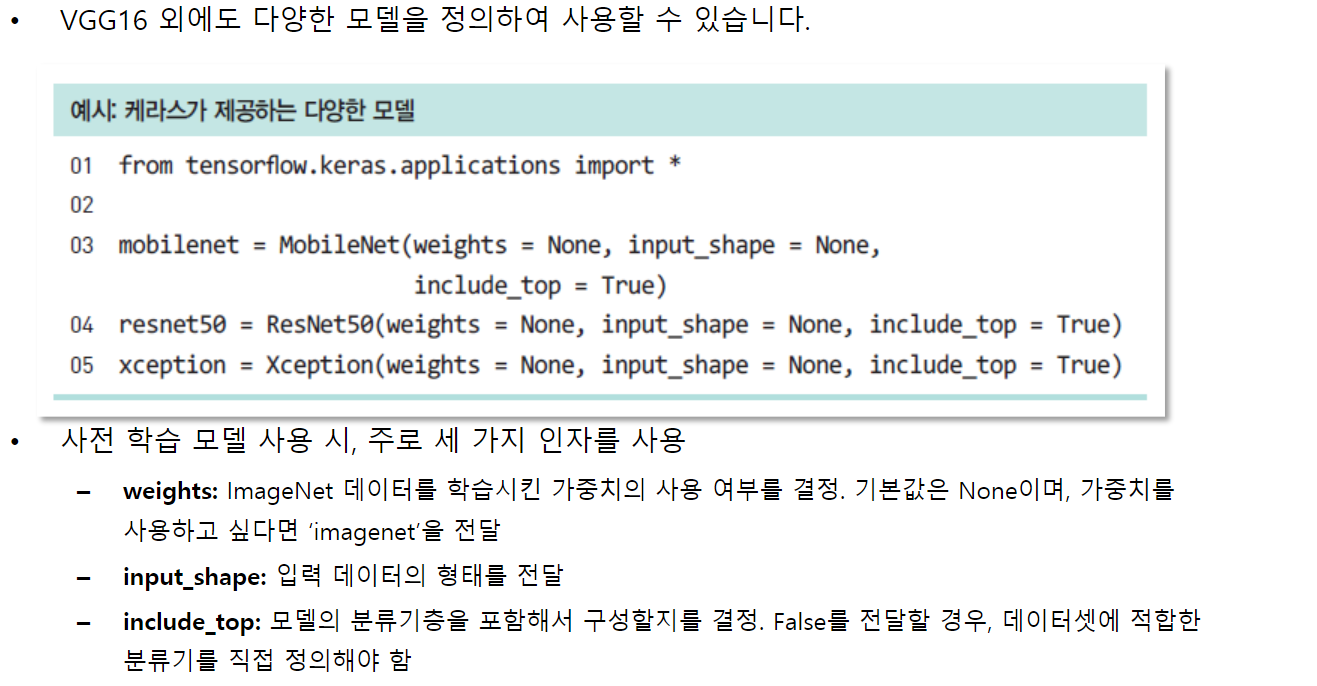

## 데이터 준비하기

In [ ]:
from tensorflow.keras.datasets import cifar10
import numpy as np

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 평균과 표준편차는 채널별로 구해줍니다.
x_mean = np.mean(x_train, axis = (0, 1, 2))
x_std = np.std(x_train, axis = (0, 1, 2))

x_train = (x_train - x_mean) / x_std
x_test = (x_test - x_mean) / x_std

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                  test_size = 0.3, random_state = 777)

# sparse_categorical_crossentropy를 사용하기 위해선 (batch_size, ) 형태를 가져야합니다.
# 따라서 np.squeeze를 사용해서 마지막 차원을 없애줍니다.
# y_train의 경우 (35000, 1) -> (35000, )이 됩니다.
y_train = np.squeeze(y_train)
y_val = np.squeeze(y_val)

print('data ready~')

170508288/170498071 [==============================] - 2s 0us/step
data ready~


## 전이 학습 사용하기

from tensorflow.keras.applications import *

+ mobilenet = MobileNet(weights = None, input_shape = None, include_top = True)
+ resnet50 = ResNet50(weights = None, input_shape = None, include_top = True)
+ xception = Xception(weights = None, input_shape = None, include_top = True)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(horizontal_flip = True,
                                   zoom_range = 0.2,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   rotation_range = 30,
                                   fill_mode = 'nearest')

val_datagen = ImageDataGenerator()

batch_size = 32

train_generator = train_datagen.flow(x_train, y_train,
                                    batch_size = batch_size)

val_generator = val_datagen.flow(x_val, y_val,
                                batch_size = batch_size)

## 사전 학습된 모델 사용하기

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import VGG16

# imagenet을 학습한 모델을 불러옵니다.
vgg16 = VGG16(weights = 'imagenet', input_shape = (32, 32, 3), include_top = False)
vgg16.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
______________________________________________________________

## 동결 해제하는 방법

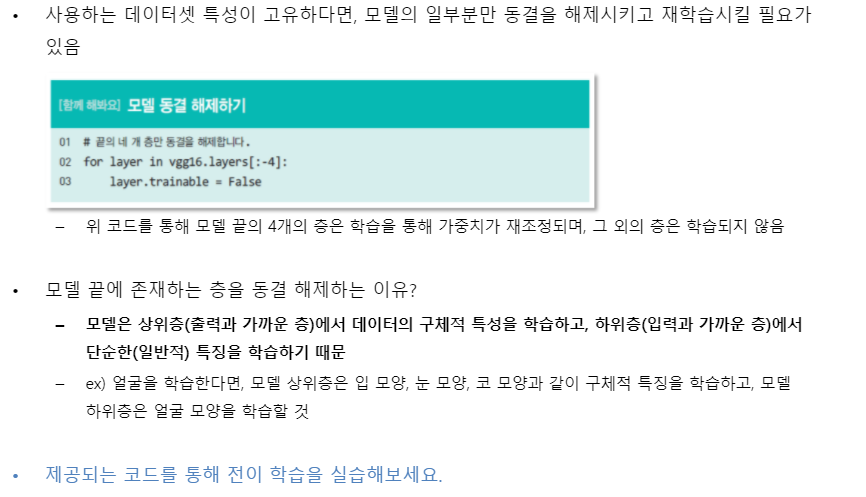

In [ ]:
# 끝의 4개의 층만 동결을 해제합니다.
# 아래 예제 결과는 동결 해제하지 않음.
# for layer in vgg16.layers[:-4]:
#     layer.trainable = False

## 모델 구성 및 학습하기

In [ ]:
model = Sequential()
# vgg16 모델을 사용합니다.
model.add(vgg16)
# 분류기를 직접 정의합니다.
model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(10, activation = 'softmax'))

# model.summary() # 모델의 구조를 확인하세요!

model.compile(optimizer = Adam(1e-4),
             loss = 'sparse_categorical_crossentropy',
             metrics = ['acc'])

def get_step(train_len, batch_size):
    if(train_len % batch_size > 0):
        return train_len // batch_size + 1
    else:
        return train_len // batch_size

history = model.fit(train_generator,
                    epochs = 100, # 50
                    steps_per_epoch = get_step(len(x_train), batch_size),
                    validation_data = val_generator,
                    validation_steps = get_step(len(x_val), batch_size))

Epoch 1/100
1094/1094 [==============================] - 45s 26ms/step - loss: 1.0639 - acc: 0.6304 - val_loss: 0.8140 - val_acc: 0.7209
Epoch 2/100
1094/1094 [==============================] - 28s 26ms/step - loss: 0.7752 - acc: 0.7343 - val_loss: 0.5967 - val_acc: 0.7917
Epoch 3/100
1094/1094 [==============================] - 28s 26ms/step - loss: 0.6764 - acc: 0.7670 - val_loss: 0.6267 - val_acc: 0.7890
Epoch 4/100
1094/1094 [==============================] - 28s 25ms/step - loss: 0.6092 - acc: 0.7916 - val_loss: 0.5709 - val_acc: 0.8102
Epoch 5/100
1094/1094 [==============================] - 28s 25ms/step - loss: 0.5558 - acc: 0.8091 - val_loss: 0.5416 - val_acc: 0.8224
Epoch 6/100
1094/1094 [==============================] - 28s 25ms/step - loss: 0.5087 - acc: 0.8264 - val_loss: 0.5737 - val_acc: 0.8173
Epoch 7/100
1094/1094 [==============================] - 28s 25ms/step - loss: 0.4870 - acc: 0.8357 - val_loss: 0.4628 - val_acc: 0.8447
Epoch 8/100
1094/1094 [==================

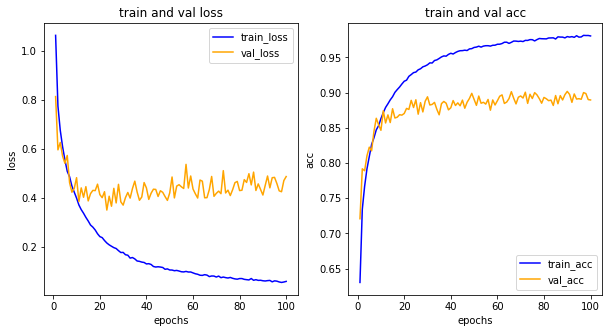

In [ ]:
import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss'] 

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize = (10, 5))

# 훈련 및 검증 손실 그리기
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['acc']
val_acc = his_dict['val_acc']

# 훈련 및 검증 정확도 그리기
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()

plt.show()

## (번외) A 모델의 가중치를 B 모델에 전이하기
+ A 모델: model  
+ B 모델: transfer_model
<br>

+ 밑의 코드는 A 모델과 B 모델의 구조가 같다는 가정이 전제됩니다.
<br>

+ set_weights: 가중치를 설정합니다.  
+ get_weights: 모델의 가중치를 가져옵니다.

In [ ]:
for i in range(len(model.layers) - 1):
    transfer_model.layers[i].set_weights(model.layers[i].get_weights())